In [1]:
%pylab inline
import sklearn.model_selection
import scipy
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import os
import random
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow_addons as tfa

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), constant=0, **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        if s[1] == None:
            return (None, None, None, s[3])
        return (s[0], s[1] + 2 * self.padding[0] , s[2] + 2 * self.padding[1] , s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad ], [w_pad, w_pad ], [0, 0]], 'REFLECT')

    def get_config(self):
        config = super(ReflectionPadding2D, self).get_config()
        print(config)
        return config
    
class ConstantPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), constant=1, **kwargs):
        self.padding = tuple(padding)
        self.constant = constant
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        super(ConstantPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        if s[1] == None:
            return (None, None, None, s[3])
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], mode='CONSTANT', constant_values=self.constant)
    
    def get_config(self):
        config = super(ConstantPadding2D, self).get_config()
        print(config)
        return config

In [15]:
def create_network(width = 64, height = 64):
    model = tf.keras.models.Sequential()
    layers = tf.keras.layers
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 1, activation = 'relu', padding = 'same', use_bias = False, input_shape=(64,64,1)))
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False))
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 1, activation = 'relu', padding = 'same', use_bias = False))

    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False))

    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 1, activation = 'relu', padding = 'same', use_bias = False))

    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False))

    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 1, activation = 'relu', padding = 'same', use_bias = False))
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False))
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 1, activation = 'relu', padding = 'same', use_bias = False))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', use_bias = False))
    model.add(layers.Dense(64, activation='relu', use_bias = False))
    model.add(layers.Dense(1, activation='relu', use_bias = False))
    
    optimizer = tf.keras.optimizers.Adam(amsgrad=True)
    model.compile(optimizer=optimizer, loss='mape')
    return model

def create_network_small(width = 64, height = 64):
    model = tf.keras.models.Sequential()
    layers = tf.keras.layers
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False, input_shape=(64,64,1)))
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False))
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False))
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False))
    
    model.add(layers.Conv2D(filters = 16, kernel_size = 4, strides = 2, activation = 'relu', padding = 'same', use_bias = False))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', use_bias = False))
    model.add(layers.Dense(32, activation='relu', use_bias = False))
    model.add(layers.Dense(16, activation='relu', use_bias = False))
    model.add(layers.Dense(1, use_bias = False))
    
    optimizer = tf.keras.optimizers.Adam(amsgrad=True)
    model.compile(optimizer=optimizer, loss='mape')
    return model

"""
padding='same',
padding='same',
padding='same',
padding='same',
padding='same',
""";

In [16]:
model = create_network_small()

In [13]:
model = tf.keras.models.load_model('models/small_1')
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mape')

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 16)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 16)        4096      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 16)          4096      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 16)          4096      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 2, 2, 16)          4096      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [18]:
def load_data(dataset):
    d = np.load(dataset)
    mask = ~(np.isclose(d['permeabilities_x'], 0) | np.isclose(d['permeabilities_y'], 0)) & ((d['permeabilities_y'] + d['permeabilities_x']) / 2 < 25)
    images = d['images'][mask]
    porosities = d['porosities'][mask]
    permeabilities = (d['permeabilities_x'][mask] + d['permeabilities_y'][mask]) / 2
    images = np.reshape(images,(*(images.shape), 1))
    d.close()
    return images, porosities.astype(np.float32), permeabilities.astype(np.float32)

def load_data_isotropic(dataset):
    d = np.load(dataset)
    mask = np.isclose(d['permeabilities_x'], d['permeabilities_y'], rtol=1) & ~np.isclose(d['permeabilities_x'], 0) & ((d['permeabilities_y'] + d['permeabilities_x']) / 2 < 25)
    images = d['images'][mask]
    porosities = d['porosities'][mask]
    permeabilities = (d['permeabilities_x'][mask] + d['permeabilities_y'][mask]) / 2
    images = np.reshape(images,(*(images.shape), 1))
    d.close()
    return images, porosities.astype(np.float32), permeabilities.astype(np.float32)

def load_data90(dataset):
    d = np.load(dataset)
    mask = ~(np.isclose(d['permeabilities_x'], 0) | np.isclose(d['permeabilities_y'], 0)) & ((d['permeabilities_y'] + d['permeabilities_x']) / 2 < 25)
    images = d['images'][mask]
    porosities = d['porosities'][mask]
    permeabilities = (d['permeabilities_x'][mask] + d['permeabilities_y'][mask]) / 2
    images = np.rot90(images,axes=(2,1))
    images = np.reshape(images,(*(images.shape), 1))
    d.close()
    return images, porosities.astype(np.float32), permeabilities.astype(np.float32)

def load_dataTranspose(dataset):
    d = np.load(dataset)
    mask = ~(np.isclose(d['permeabilities_x'], 0) | np.isclose(d['permeabilities_y'], 0)) & ((d['permeabilities_y'] + d['permeabilities_x']) / 2 < 25)
    images = d['images'][mask]
    porosities = d['porosities'][mask]
    permeabilities = (d['permeabilities_x'][mask] + d['permeabilities_y'][mask]) / 2
    images = np.transpose(images,axes=(0,2,1))
    images = np.reshape(images,(*(images.shape), 1))
    d.close()
    return images, porosities.astype(np.float32), permeabilities.astype(np.float32)

def load_data_xy(dataset):
    d = np.load(dataset)
    mask = ~(np.isclose(d['permeabilities_x'], 0) | np.isclose(d['permeabilities_y'], 0)) & ((d['permeabilities_y'] + d['permeabilities_x']) / 2 < 25)
    images = d['images'][mask]
    porosities = d['porosities'][mask]
    permeabilities = np.vstack((d['permeabilities_x'][mask], d['permeabilities_y'][mask])).T
    images = np.reshape(images,(*(images.shape), 1))
    d.close()
    return images, porosities.astype(np.float32), permeabilities.astype(np.float32)
    

In [19]:
all_datasets = os.listdir('datasetsXY')
random.shuffle(all_datasets)
datasets = all_datasets
print(datasets)

['gaussian_sig1.5-3_f0.1-0.6_n100000.npz', 'normal_rad3pm0.5_num120-160_2_n100000.npz', 'gaussian_sig1.5-2.5_f0.1-0.5_n100000.npz', 'normal_rad4pm2_num30-120_n100000.npz', 'normal_rad5pm0.5_num30-60_n100000.npz', 'gaussian_sig1.5-3_f0.1-0.5_n100000.npz', 'gaussian_sig1.5-2.5_f0.2-0.5_n100000.npz', 'normal_rad3pm0.5_num120-160_n100000.npz', 'normal_rad4pm2_num30-120_2_n100000.npz', 'normal_rad5pm0.5_num30-60_2_n100000.npz']


In [10]:
#datasets = ['normal_rad5pm0.5_num30-60_2_n100000.npz']

Zero (or almost zero) permeabilities have to be filtered out as they do not play nicely with the neural network

In [20]:
history = []
images = []
permeabilities = []
for dataset in datasets:
    images_n, _, permeabilities_n = load_data('datasetsXY/' + dataset)
    images.extend(images_n)
    permeabilities.extend(permeabilities_n)
    del(images_n)
    del(permeabilities_n)

    """
    images_n, _, permeabilities_n = load_data90('datasetsXY/' + dataset)
    images.extend(images_n)
    permeabilities.extend(permeabilities_n)
    del(images_n)
    del(permeabilities_n)
    images_n, porosities_n, permeabilities_n = load_dataTranspose('datasetsXY/' + dataset)
    images.append(images_n)
    porosities.append(porosities_n)
    permeabilities.append(permeabilities_n)
    """

permeabilities = np.array(permeabilities)
images = np.array(images)

In [21]:
images_train, images_test, permeabilities_train, permeabilities_test = sklearn.model_selection.train_test_split(images, permeabilities, test_size=0.33)

In [22]:
epochs = 200

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 10, mode = 'min', monitor = 'val_loss', restore_best_weights=True)
]

history = model.fit(
    images_train,
    permeabilities_train,
    validation_data = (images_test, permeabilities_test),
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/200
15894/15894 [==============================] - 47s 3ms/step - loss: 30.7267 - val_loss: 22.6504
Epoch 2/200
15894/15894 [==============================] - 46s 3ms/step - loss: 21.3737 - val_loss: 19.5193
Epoch 3/200
15894/15894 [==============================] - 48s 3ms/step - loss: 19.0046 - val_loss: 20.2365
Epoch 4/200
15894/15894 [==============================] - 46s 3ms/step - loss: 17.7454 - val_loss: 17.1982
Epoch 5/200
15894/15894 [==============================] - 46s 3ms/step - loss: 16.8812 - val_loss: 18.3738
Epoch 6/200
15894/15894 [==============================] - 46s 3ms/step - loss: 16.2471 - val_loss: 15.9810
Epoch 7/200
15894/15894 [==============================] - 46s 3ms/step - loss: 15.6401 - val_loss: 15.1074
Epoch 8/200
15894/15894 [==============================] - 46s 3ms/step - loss: 15.2403 - val_loss: 14.8227ETA: 
Epoch 9/200
15894/15894 [==============================] - 46s 3ms/step - loss: 14.9450 - val_loss: 15.9914
Epoch 10/200
15894/1589

(0.019175068, 24.974936)

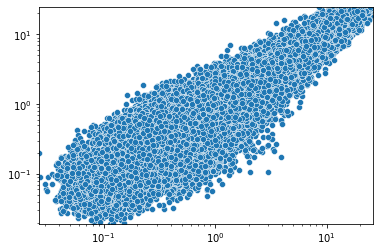

In [110]:
predicted_premeabilities = model.predict(images_test).flatten()
ax = sns.scatterplot(x = predicted_premeabilities, y = permeabilities_test)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(predicted_premeabilities[predicted_premeabilities>0]),np.max(predicted_premeabilities)])
ax.set_ylim([np.min(permeabilities_test),np.max(permeabilities_test)])

In [111]:
model.evaluate(images_test, permeabilities_test)

6059/6059 [==============================] - 6s 957us/step - loss: 42.7398


42.73981857299805

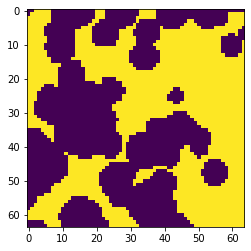

In [21]:
errors = np.abs((permeabilities_test - predicted_premeabilities) / permeabilities_test)*100
max_err_idx = np.argmax(errors)
plt.imshow(images_test[max_err_idx])

In [ ]:
model.evaluate(np.concatenate((images_test, images_train)), np.concatenate((permeabilities_test, permeabilities_train)))

In [ ]:
np.concatenate((images_test, images_train)).shape

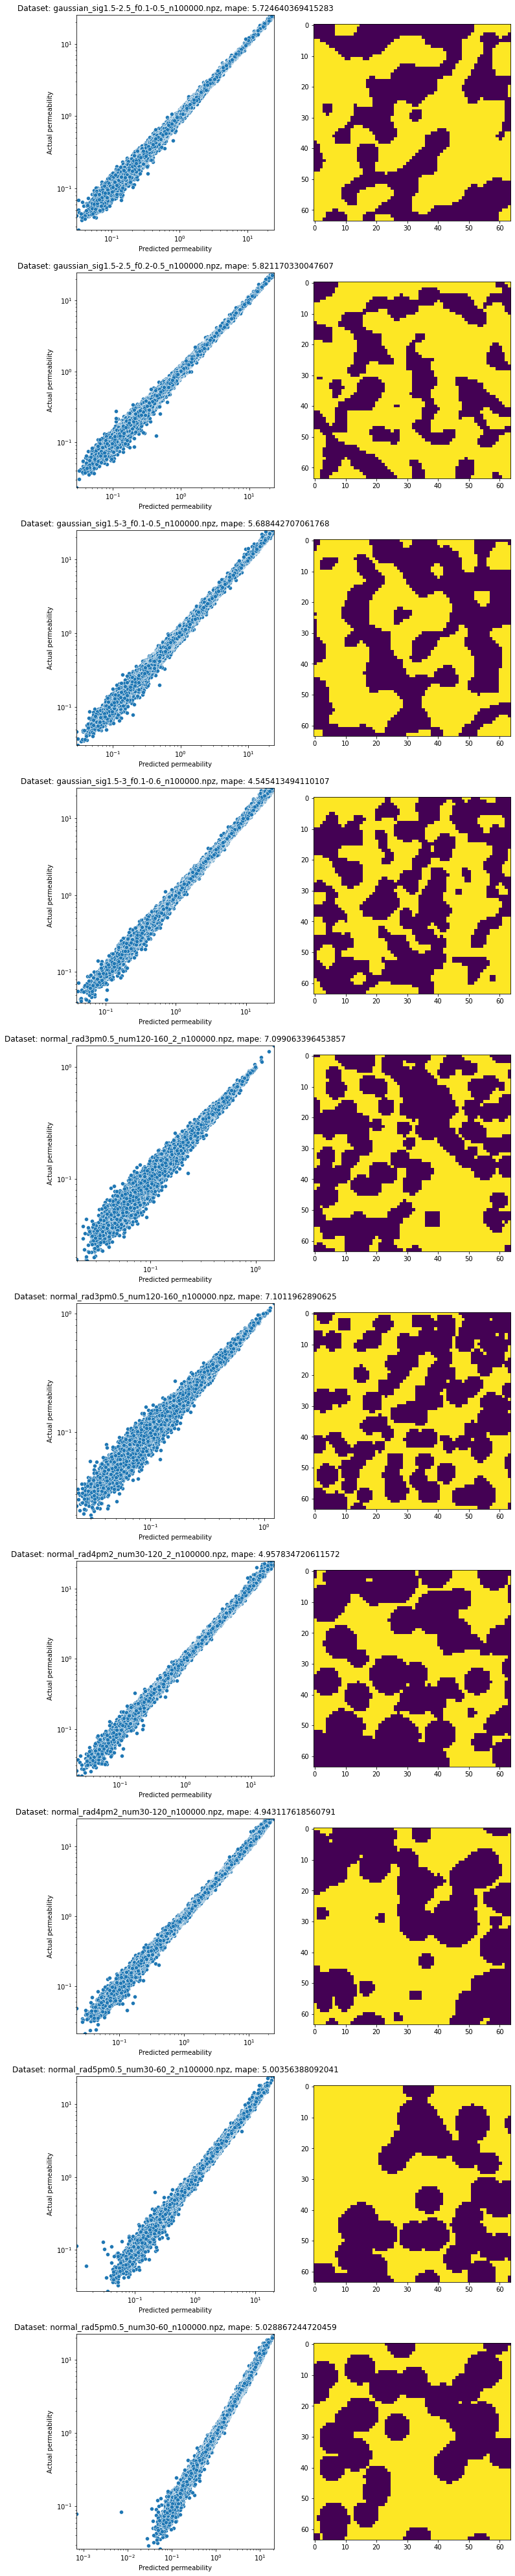

In [13]:
datasets = os.listdir('datasetsXY')

fig, axes = plt.subplots(len(datasets), 2, figsize=(12,6*12))

for i in range(len(datasets)):
    images, porosities, permeabilities = load_data('datasetsXY/' + datasets[i])
    predicted = model.predict(images).flatten()
    
    errors = np.abs((permeabilities - predicted) / permeabilities)*100
    max_err_idx = np.argmax(errors)
    
    sns.scatterplot(ax = axes[i, 0], x = predicted, y = permeabilities)
    axes[i,1].imshow(images[max_err_idx])
    #axes[i,1].set_title(f'Largest error input k={permeabilities[max_err_idx]}, k_predicted={predicted[max_err_idx]}')

    axes[i,0].set_xscale('log')
    axes[i,0].set_yscale('log')
    axes[i,0].set_xlim([np.min(predicted[predicted>0]),np.max(predicted)])
    axes[i,0].set_ylim([np.min(permeabilities[permeabilities>0]),np.max(permeabilities)])
    axes[i,0].set_xlabel('Predicted permeability');
    axes[i,0].set_ylabel('Actual permeability');
    axes[i,0].set_title(f'Dataset: {datasets[i]}, mape: {np.mean(errors)}')

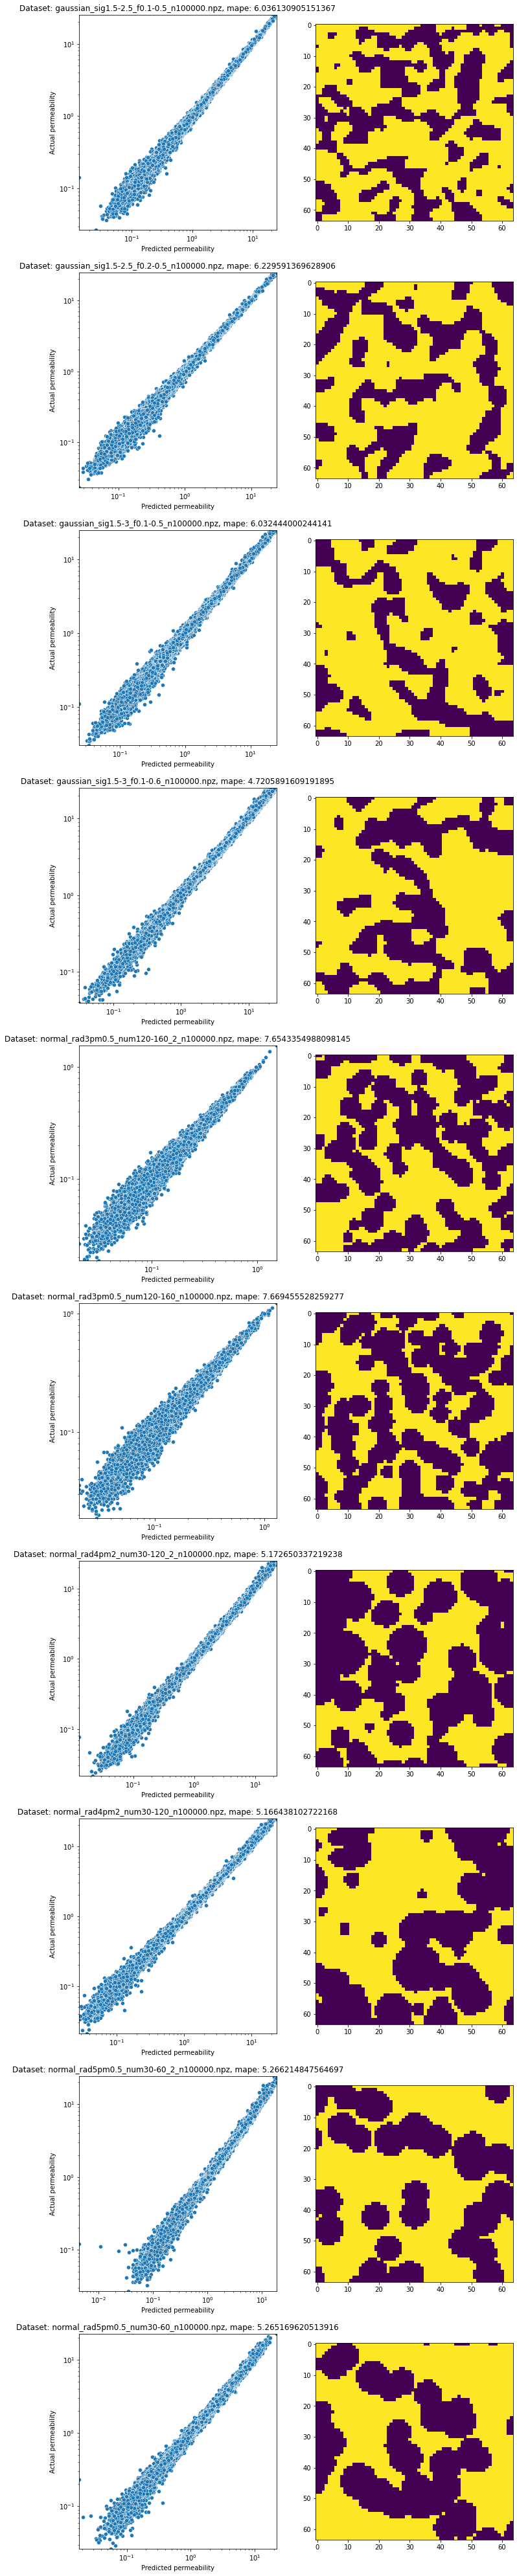

In [14]:
datasets = os.listdir('datasetsXY')

fig, axes = plt.subplots(len(datasets), 2, figsize=(12,6*12))

for i in range(len(datasets)):
    images, porosities, permeabilities = load_data90('datasetsXY/' + datasets[i])
    predicted = model.predict(images).flatten()
    
    errors = np.abs((permeabilities - predicted) / permeabilities)*100
    max_err_idx = np.argmax(errors)
    
    sns.scatterplot(ax = axes[i, 0], x = predicted, y = permeabilities)
    axes[i,1].imshow(images[max_err_idx])
    #axes[i,1].set_title(f'Largest error input k={permeabilities[max_err_idx]}, k_predicted={predicted[max_err_idx]}')

    axes[i,0].set_xscale('log')
    axes[i,0].set_yscale('log')
    axes[i,0].set_xlim([np.min(predicted[predicted>0]),np.max(predicted)])
    axes[i,0].set_ylim([np.min(permeabilities[permeabilities>0]),np.max(permeabilities)])
    axes[i,0].set_xlabel('Predicted permeability');
    axes[i,0].set_ylabel('Actual permeability');
    axes[i,0].set_title(f'Dataset: {datasets[i]}, mape: {np.mean(errors)}')

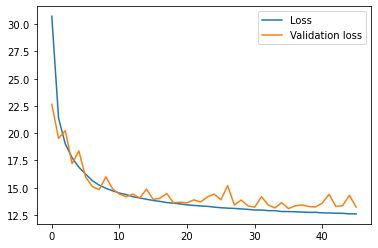

In [24]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.legend(('Loss', 'Validation loss'))

In [23]:
name = 'small_2'
model.save(f'models/{name}')
with open(f'models/{name}.history', 'wb') as hist_file:
    pickle.dump(history.history, hist_file)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/small_2\assets
